In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_fine']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_fine'])
#df = df[df['y_fine'] > 10000]
#df = df[df['y_fine'] <= 3000000] # 하위 99%

In [4]:
X = df.drop('y_fine', axis=1)
#y = df['y_fine']/1000000
y = df['y_fine']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 256

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(dfc.columns[1:]),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(dfl.columns[1:]),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.5)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.5)(dense_layer_2_4)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0825_6.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 200
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

15864


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_4)

model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=['mape', 'mae', 'mse'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 200)     3172800     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 153)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 567)]        0                                            
______________________________________________________________________________________________

In [13]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1)

Train on 1285 samples, validate on 143 samples
Epoch 1/150
1285/1285 [==============================] - 4s 3ms/sample - loss: 100.7260 - mape: 99.9996 - mae: 142376032.0000 - mse: 3041287920213295104.0000 - val_loss: 100.1608 - val_mape: 99.9999 - val_mae: 38184720.0000 - val_mse: 24951064897781760.0000
Epoch 2/150
1285/1285 [==============================] - 1s 815us/sample - loss: 100.1809 - mape: 99.9990 - mae: 142376048.0000 - mse: 3041287645335388160.0000 - val_loss: 100.1805 - val_mape: 99.9998 - val_mae: 38184720.0000 - val_mse: 24951064897781760.0000
Epoch 3/150
1285/1285 [==============================] - 1s 788us/sample - loss: 100.1799 - mape: 99.9985 - mae: 142376048.0000 - mse: 3041287645335388160.0000 - val_loss: 100.1723 - val_mape: 99.9997 - val_mae: 38184716.0000 - val_mse: 24951064897781760.0000
Epoch 4/150
1285/1285 [==============================] - 1s 852us/sample - loss: 100.1813 - mape: 99.9979 - mae: 142376032.0000 - mse: 3041288469969108992.0000 - val_loss: 100

1285/1285 [==============================] - 1s 810us/sample - loss: 100.0561 - mape: 99.6600 - mae: 142373424.0000 - mse: 3041287920213295104.0000 - val_loss: 100.0102 - val_mape: 99.7753 - val_mae: 38181692.0000 - val_mse: 24950824379613184.0000
Epoch 33/150
1285/1285 [==============================] - 1s 803us/sample - loss: 100.1550 - mape: 99.7456 - mae: 142372992.0000 - mse: 3041287095579574272.0000 - val_loss: 99.8295 - val_mape: 99.7569 - val_mae: 38181432.0000 - val_mse: 24950809347227648.0000
Epoch 34/150
1285/1285 [==============================] - 1s 804us/sample - loss: 100.1924 - mape: 99.7173 - mae: 142372464.0000 - mse: 3041286545823760384.0000 - val_loss: 99.8124 - val_mape: 99.7215 - val_mae: 38180956.0000 - val_mse: 24950772840005632.0000
Epoch 35/150
1285/1285 [==============================] - 1s 805us/sample - loss: 100.2206 - mape: 99.7526 - mae: 142372144.0000 - mse: 3041286820701667328.0000 - val_loss: 99.7396 - val_mape: 99.7088 - val_mae: 38180780.0000 - val_

Epoch 64/150
1285/1285 [==============================] - 1s 867us/sample - loss: 96.6030 - mape: 95.9647 - mae: 142292016.0000 - mse: 3041264280713297920.0000 - val_loss: 94.1027 - val_mape: 93.8471 - val_mae: 38091156.0000 - val_mse: 24943965316841472.0000
Epoch 65/150
1285/1285 [==============================] - 1s 854us/sample - loss: 96.7049 - mape: 95.9023 - mae: 142280384.0000 - mse: 3041263730957484032.0000 - val_loss: 93.3771 - val_mape: 93.3023 - val_mae: 38080360.0000 - val_mse: 24943147125571584.0000
Epoch 66/150
1285/1285 [==============================] - 1s 845us/sample - loss: 96.1296 - mape: 95.3054 - mae: 142268400.0000 - mse: 3041263181201670144.0000 - val_loss: 92.8596 - val_mape: 92.7285 - val_mae: 38068988.0000 - val_mse: 24942283837145088.0000
Epoch 67/150
1285/1285 [==============================] - 1s 840us/sample - loss: 96.3166 - mape: 95.6019 - mae: 142258160.0000 - mse: 3041262081690042368.0000 - val_loss: 92.7313 - val_mape: 92.3023 - val_mae: 38060552.000

Epoch 96/150
1285/1285 [==============================] - 1s 837us/sample - loss: 87.8699 - mape: 87.4375 - mae: 141975232.0000 - mse: 3041181542463307776.0000 - val_loss: 85.5548 - val_mape: 83.1479 - val_mae: 37772556.0000 - val_mse: 24918850495578112.0000
Epoch 97/150
1285/1285 [==============================] - 1s 838us/sample - loss: 90.2845 - mape: 89.3499 - mae: 141973824.0000 - mse: 3041180717829586944.0000 - val_loss: 83.3947 - val_mape: 83.1293 - val_mae: 37775248.0000 - val_mse: 24919097456197632.0000
Epoch 98/150
1285/1285 [==============================] - 1s 825us/sample - loss: 89.2112 - mape: 88.5372 - mae: 141970272.0000 - mse: 3041182641974935552.0000 - val_loss: 83.1700 - val_mape: 83.0578 - val_mae: 37763524.0000 - val_mse: 24918066664046592.0000
Epoch 99/150
1285/1285 [==============================] - 1s 832us/sample - loss: 89.2094 - mape: 88.5658 - mae: 141968528.0000 - mse: 3041163400521449472.0000 - val_loss: 83.0540 - val_mape: 83.0162 - val_mae: 37758308.000

1285/1285 [==============================] - 1s 836us/sample - loss: 83.2514 - mape: 82.7136 - mae: 141811680.0000 - mse: 3041108974695874560.0000 - val_loss: 83.7451 - val_mape: 82.5829 - val_mae: 37618128.0000 - val_mse: 24904215394516992.0000ss: 83.1855 - mape: 82.6498 - mae: 145076448.0000 - mse: 3130972060034007040.00
Epoch 128/150
1285/1285 [==============================] - 1s 832us/sample - loss: 84.2141 - mape: 83.6236 - mae: 141807504.0000 - mse: 3041129315660988416.0000 - val_loss: 83.0326 - val_mape: 82.5130 - val_mae: 37629136.0000 - val_mse: 24905175319707648.0000
Epoch 129/150
1285/1285 [==============================] - 1s 832us/sample - loss: 82.7256 - mape: 82.1502 - mae: 141799024.0000 - mse: 3041142784678428672.0000 - val_loss: 83.2718 - val_mape: 82.4690 - val_mae: 37629568.0000 - val_mse: 24905164582289408.0000
Epoch 130/150
1285/1285 [==============================] - 1s 841us/sample - loss: 83.6669 - mape: 83.0686 - mae: 141822816.0000 - mse: 3041133438829592576

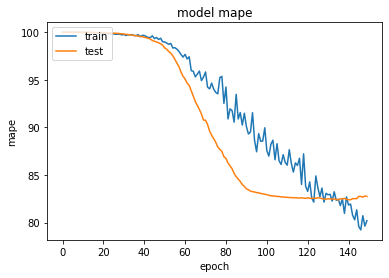

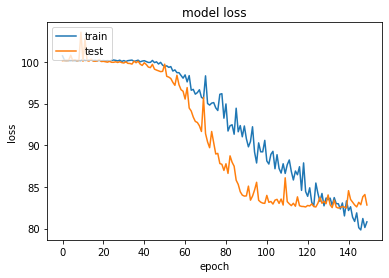

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])

plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)
print(score)
#print("Test Score:", score[0])
print("Test MAPE: ", score[1])
print("Test MAE: ", score[2])
print("Test MSE:", score[3])

159/159 [==============================] - 0s 2ms/sample - loss: 85.4743 - mape: 85.3977 - mae: 407050048.0000 - mse: 19728196288580157440.0000
[85.47429532225027, 85.39773, 407050050.0, 1.9728196e+19]
Test MAPE:  85.39773
Test MAE:  407050050.0
Test MSE: 1.9728196e+19
